In [1]:
from custom_lstm import CustomLSTM

In [2]:
import os
import numpy
import pandas
import seaborn
import tensorflow
from datetime import datetime
from matplotlib import pyplot
from tensorflow import losses, metrics
from tensorflow.keras import layers, models, utils, preprocessing, activations, optimizers, callbacks

In [3]:
#Tries to enable dynamic memory allocation on GP
try:
    for i in tensorflow.config.experimental.list_physical_devices("GPU"):
        tensorflow.config.experimental.set_memory_growth(i, True)
except:
    print("Device dynamic memory allocation failed!")

In [4]:
seaborn.set_style("darkgrid")

In [5]:
df_train = pandas.read_csv("train.tsv", sep='\t')
print("train set: {0}".format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [6]:
df_test = pandas.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [7]:
replace_list = {r"i'm": 'i am', r"'re": ' are', r"let’s": 'let us', r"'s":  ' is', r"'ve": ' have', r"can't": 'can not', r"cannot": 'can not', r"shan’t": 'shall not', r"n't": ' not',
                r"'d": ' would', r"'ll": ' will', r"'scuse": 'excuse', ',': ' ,', '.': ' .', '!': ' !', '?': ' ?', '\s+': ' '}

In [8]:
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [9]:
X_train = df_train["Phrase"].apply(lambda p: clean_text(p))
X_test = df_test["Phrase"].apply(lambda p: clean_text(p))

In [10]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))

max phrase len: 53


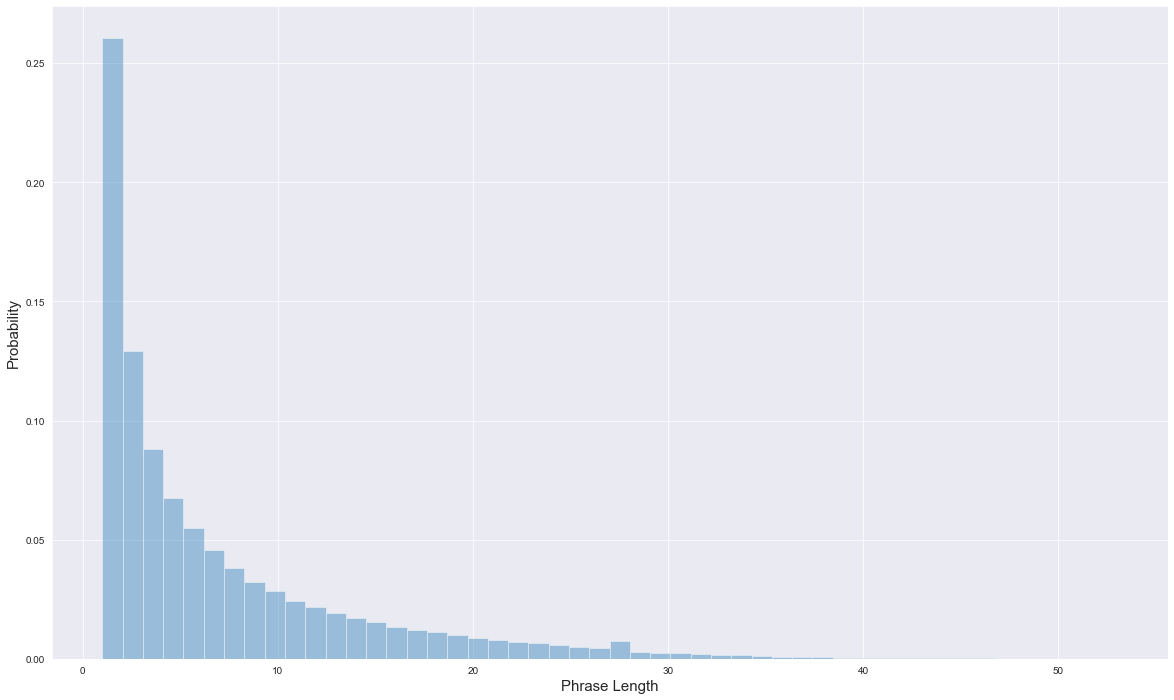

In [11]:
_, axis = pyplot.subplots(figsize=(20, 12))
seaborn.distplot(phrase_len, kde=False, norm_hist=True)
axis.set_ylabel("Probability", fontsize=15)
axis.set_xlabel("Phrase Length", fontsize=15)
pyplot.show()

In [12]:
y_train = df_train['Sentiment']

In [13]:
max_words = 8192
tokenizer = preprocessing.text.Tokenizer(num_words=max_words, filters='"#$%&()*+-/:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_phrase_len)
y_train = utils.to_categorical(y_train)

In [14]:
u = numpy.unique(y_train, return_counts=True, axis=0)

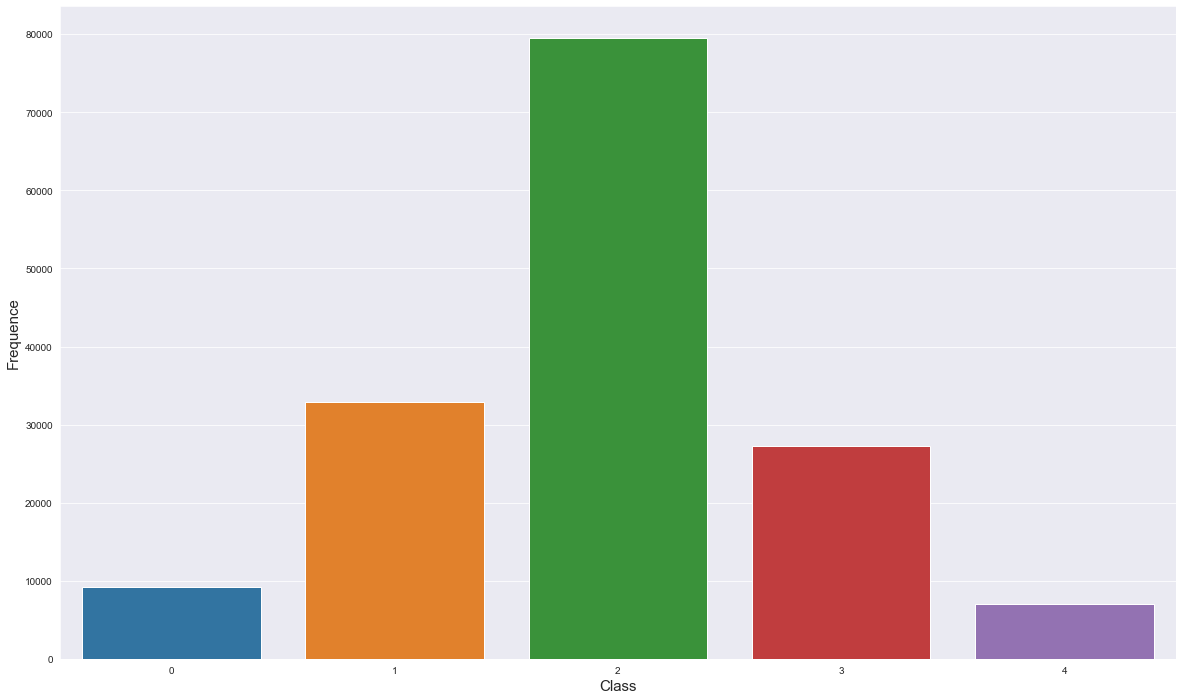

In [15]:
_, axis = pyplot.subplots(figsize=(20, 12))
seaborn.barplot(x=[i for i in range(u[0].shape[0])], y=u[1])
axis.set_ylabel("Frequence", fontsize=15)
axis.set_xlabel("Class", fontsize=15)
pyplot.show()

In [16]:
test_phrase_len = X_test.apply(lambda p: len(p.split(' ')))
test_max_phrase_len = test_phrase_len.max()

In [17]:
max_words = 8192
tokenizer = preprocessing.text.Tokenizer(num_words=max_words, filters='"#$%&()*+-/:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(X_test)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_phrase_len)

In [18]:
metrics_list = [metrics.CategoricalAccuracy(), metrics.Precision(), metrics.Recall(), metrics.AUC()]
model_lstm = models.Sequential()
model_lstm.add(layers.Embedding(input_dim=max_words, output_dim=256, input_length=max_phrase_len))
model_lstm.add(CustomLSTM(256, activation=activations.tanh))
model_lstm.add(layers.Dense(256, activation=activations.relu))
model_lstm.add(layers.Dense(128, activation=activations.relu))
model_lstm.add(layers.Dense(64, activation=activations.relu))
model_lstm.add(layers.Dense(32, activation=activations.relu))
model_lstm.add(layers.Dense(5, activation=activations.softmax))
model_lstm.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=0.001), metrics=metrics_list)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 256)           2097152   
_________________________________________________________________
custom_lstm (CustomLSTM)     (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1

In [19]:
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

In [20]:
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=2048, validation_data=(X_train, y_train), callbacks=[tensorboard_callback])

Train on 156060 samples, validate on 156060 samples
Epoch 1/10
156060/156060 [==============================] - 43s 278us/sample - loss: 1.2210 - categorical_accuracy: 0.5130 - precision: 0.6775 - recall: 0.3348 - auc: 0.7989 - val_loss: 1.0932 - val_categorical_accuracy: 0.5495 - val_precision: 0.6983 - val_recall: 0.4342 - val_auc: 0.8406
Epoch 2/10
156060/156060 [==============================] - 38s 246us/sample - loss: 1.0156 - categorical_accuracy: 0.5898 - precision: 0.7192 - recall: 0.4489 - auc: 0.8660 - val_loss: 0.8729 - val_categorical_accuracy: 0.6527 - val_precision: 0.7247 - val_recall: 0.5354 - val_auc: 0.9030
Epoch 3/10
156060/156060 [==============================] - 39s 247us/sample - loss: 0.8452 - categorical_accuracy: 0.6591 - precision: 0.7082 - recall: 0.5765 - auc: 0.9078 - val_loss: 0.7802 - val_categorical_accuracy: 0.6870 - val_precision: 0.7286 - val_recall: 0.6154 - val_auc: 0.9213
Epoch 4/10
156060/156060 [==============================] - 39s 248us/sampl

In [22]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 8668), started 0:01:24 ago. (Use '!kill 8668' to kill it.)

In [22]:
y = model_lstm.predict_classes(X_test)

In [27]:
u = numpy.unique(y, return_counts=True)

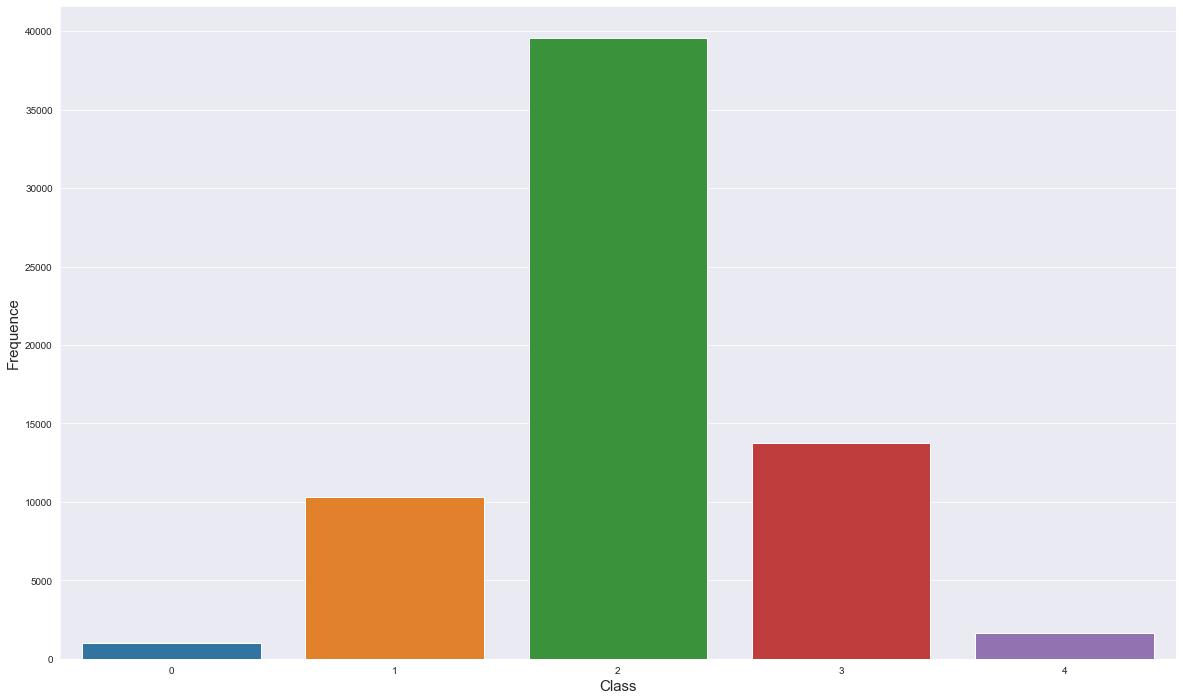

In [28]:
_, axis = pyplot.subplots(figsize=(20, 12))
seaborn.barplot(x=u[0], y=u[1])
axis.set_ylabel("Frequence", fontsize=15)
axis.set_xlabel("Class", fontsize=15)
pyplot.show()